## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
 reduce_factor: 0.50, reduce_patient: 5 delivers the best result
 
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果


In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25  # Reduce the value if it takes too long to finish
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.8]
redice_lr_patient = [5,10]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 5s 108us/step - loss: 1.2338 - acc: 0.5739 - val_loss: 1.4799 - val_acc: 0.4764
Epoch 14/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.2094 - acc: 0.5828 - val_loss: 1.4649 - val_acc: 0.4853
Epoch 15/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1847 - acc: 0.5933 - val_loss: 1.4602 - val_acc: 0.4922
Epoch 16/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1627 - acc: 0.5999 - val_loss: 1.4546 - val_acc: 0.4933
Epoch 17/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.1388 - acc: 0.6094 - val_loss: 1.4571 - val_acc: 0.4881
Epoch 18/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1187 - acc: 0.6166 - val_loss: 1.4586 - val_acc: 0.4930
Epoch 19/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.0971 - acc: 0.6243 - val_loss: 1.4486 - val_acc: 0.4968
Epoch 20/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.1905 - acc: 0.2742 - val_loss: 2.0817 - val_acc: 0.3163
Epoch 2/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.7353 - acc: 0.3981 - val_loss: 1.8008 - val_acc: 0.3803
Epoch 3/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.6148 - acc: 0.4346 - val_loss: 1.6829 - val_acc: 0.4078
Epoch 4/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.5397 - acc: 0.4624 - val_loss: 1.6221 - val_acc: 0.4246
Epoch 5/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4869 - acc: 0.4818 - val_loss: 1.6005 - val_acc: 0.4330
Epoch 6/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.4401 - acc: 0.4980 - val_loss: 1.5582 - val_acc: 0.4493
Epoch 7/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.4022 - acc: 0.5117 - val_loss: 1.5390 - 


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 23/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.4669 - acc: 0.8626 - val_loss: 1.5005 - val_acc: 0.5306
Epoch 24/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.4443 - acc: 0.8719 - val_loss: 1.5235 - val_acc: 0.5282
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.4325 - acc: 0.8765 - val_loss: 1.5419 - val_acc: 0.5284
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)       

50000/50000 [==============================] - 6s 115us/step - loss: 1.1334 - acc: 0.6113 - val_loss: 1.4795 - val_acc: 0.4787
Epoch 10/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.1002 - acc: 0.6257 - val_loss: 1.4595 - val_acc: 0.4897
Epoch 11/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.0709 - acc: 0.6348 - val_loss: 1.4421 - val_acc: 0.4960
Epoch 12/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.0393 - acc: 0.6498 - val_loss: 1.4355 - val_acc: 0.4983
Epoch 13/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.0122 - acc: 0.6582 - val_loss: 1.4496 - val_acc: 0.4953
Epoch 14/25
50000/50000 [==============================] - 6s 117us/step - loss: 0.9857 - acc: 0.6698 - val_loss: 1.4257 - val_acc: 0.5000
Epoch 15/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.9587 - acc: 0.6807 - val_loss: 1.4695 - val_acc: 0.4939
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.7986 - acc: 0.3744 - val_loss: 2.0131 - val_acc: 0.3412
Epoch 2/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.5360 - acc: 0.4569 - val_loss: 2.2711 - val_acc: 0.2944
Epoch 3/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.4347 - acc: 0.4943 - val_loss: 2.6877 - val_acc: 0.2743
Epoch 4/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.3616 - acc: 0.5202 - val_loss: 2.2380 - val_acc: 0.2821
Epoch 5/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2955 - acc: 0.5431 - val_loss: 2.4964 - val_acc: 0.2898
Epoch 6/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.2411 - acc: 0.5608 - val_loss: 1.8679 - val_acc: 0.3754
Epoch 7/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1963 - acc: 0.5789 - val_loss: 2.7336 - 

Epoch 23/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.7012 - acc: 0.7671 - val_loss: 1.8705 - val_acc: 0.4301
Epoch 24/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.6786 - acc: 0.7758 - val_loss: 1.7956 - val_acc: 0.4436
Epoch 25/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.6534 - acc: 0.7847 - val_loss: 1.8451 - val_acc: 0.4436
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
______________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.0896 - acc: 0.6261 - val_loss: 1.6867 - val_acc: 0.4325
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.0530 - acc: 0.6396 - val_loss: 1.5383 - val_acc: 0.4650
Epoch 12/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.0166 - acc: 0.6548 - val_loss: 2.3212 - val_acc: 0.3492
Epoch 13/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.9863 - acc: 0.6641 - val_loss: 1.8165 - val_acc: 0.4041
Epoch 14/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.9540 - acc: 0.6749 - val_loss: 1.9000 - val_acc: 0.3833
Epoch 15/25
50000/50000 [==============================] - 6s 114us/step - loss: 0.9192 - acc: 0.6913 - val_loss: 1.7985 - val_acc: 0.4126
Epoch 16/25
50000/50000 [==============================] - 6s 116us/step - loss: 0.8917 - acc: 0.6993 - val_loss: 1.6140 - val_acc: 0.4532
Epoch 17/25
50000/50000 [==

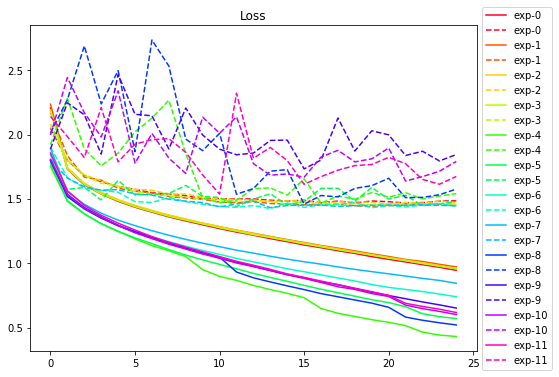

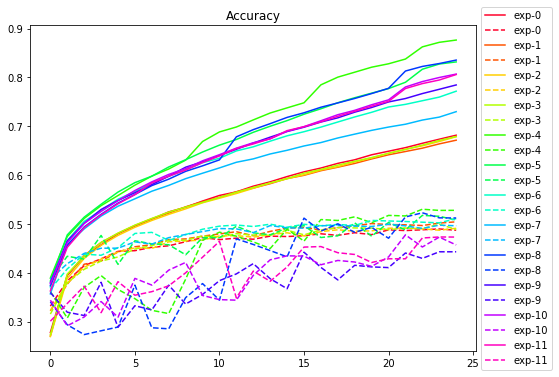

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()